# ROADMAP
1. Import HI3 Builds Dataset `HI3_Data.xlsx`
2. View statistics on the equipped stigmas (weapons are usually unique to each character) (e.g., most used stigma, least used, etc)
3. Convert Excel dataset to NumPy array and filter out unnecessary information (e.g., name, battlesuit date released)
   1. Make a PyTorch Dataset (`torch.utils.data.Dataset`) class to do this, using the link to parse without overloading memory
      1. You will split the datasets into training and testing respectively
   2. Make a PyTorch Dataloader (`torch.utils.data.DataLoader`) to do this, it will be split for you via batches
4. Define the AI model and make it trainable on the # of features/classes we have
   1. Define the training loop
5. Validate the model by using the testing dataset (X_test, y_test)
6. Make a prediction with a new character

**TODO** look at t-test and chi-square test

Goal: Given every feature in the Excel spreadsheet, have a model predict the appropriate weapon and stigma

## 0. Setup

In [1]:
# install openpyxl
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel

## 1. Import HI3 Builds Dataset @ `HI3_Data.xlsx`

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# note: wsl spreadsheet is symlink to documents folder on windows
df = pd.read_excel("HI3_Data.xlsx")
df.head(5)

,Battlesuit,Release Date,Default Rank,Battlesuit Type,Damage Type,Optimal Role,Optimal Weapon,Stigma (T),Stigma (M),Stigma (B),...,Wheel of Destiny Optimal Role,Leader Buff,Passive Buff,Evasion,Weapon Skills,Basic ATK,Ultimate,Special Attack,Astral Ring,SP
0,Schicksal's Imperative,2024-09-05,S,Quantum,Lightning,DPS,Vacation Notice,Day After Day (T),Day After Day (M),Day After Day (B),...,Support,Activates World Star and unlocks enhancements ...,Build up Stress during Don't Wanna Work and re...,Evade or jump to dodge enemy attacks. Can evad...,Attack together with puppets.\nDuring Don't Wa...,Fight using the Request-Declining Blade that h...,Schicksal's Imperative falls asleep on the spo...,Fight using the Message-Blocking Swatter or Wo...,Unleash the power of Astral Ring to enhance th...,NaN
1,Deepspace Anchor: First Light,2024-02-29,S,Stardust,Lightning,DPS,Red Star Thunderbolt,Perfect Morning (T),Perfect Morning (M),Perfect Morning (B),...,Support,Activate Astral Ring Specialization: World Sta...,Consume Thunderous Pulse to enter Thunderous B...,Evade or jump to dodge enemy attacks. Can evad...,Quickly approach the enemy via the drive core ...,Swing the drive core to damage enemies.\nTap [...,Weaves the drive core between enemies before c...,Weaves the drive core between enemies before c...,Unleash Astral Ring's power and enhance the ch...,NaN
2,Valkyrie Boltstorm,2024-02-29,A,Mecha,Lightning,Support,Electrifying Arc,Von Neumann (T),Von Neumann (M),Von Neumann (B),...,NaN,Activate Astral Ring Specialization: World Sta...,Gain Rapid Shot Energy.\nRapid Shot Energy cap...,Evade or jump to dodge enemy attacks. Can evad...,Throw an explosive device at the enemy.\nTap [...,Nimbly pummel the enemy.\nTap [ATK] on the gro...,Detonate a deadly explosive device.\nAfter usi...,A rapid onslaught of bolts.\nWhen Valkyrie Bol...,Unleash Astral Ring's power to enhance the cha...,NaN
3,Mad Pleasure: Shadowbringer,2024-04-25,S,Mecha,Ice,Both,Banquet Rose,Splendors of Amber (T),Splendors of Amber (M),Splendors of Amber (B),...,DPS,Activates Astral Ring Specialization: Wheel of...,Moment of Indulgence can be performed when Ban...,Evade or jump to dodge enemy attacks. On the g...,Swings the long chain to attack.\nTap [Weapon]...,Fast attacks with two blades.\nTap [ATK] on th...,Ravage enemies before finishing them off.\nAft...,An attack that switches between ground and aer...,Unleashes Astral Ring's power and enhances the...,NaN
4,Lone Destruction: Shadowchaser,2024-06-06,S,Psychic,Fire,DPS,Burn the Long Night,Lantern Guardian (T),Lantern Guardian (M),Lantern Guardian (B),...,DPS,Activates Wheel of Destiny and provides enhanc...,Consume ammo to refill Blast Energy.\nThe char...,Evade or jump to dodge enemy attacks. Can evad...,Switch firearms.\nTap [Weapon] to switch basic...,Attack with three basic firearms.\nRapid-Shot ...,Go all out against the enemy with afterimages....,Launch a HE Round with a rocket launcher.\nAt ...,Unleash Astral Ring's power to enhance the cha...,NaN


In [4]:
df.columns

Index(['Battlesuit', 'Release Date', 'Default Rank', 'Battlesuit Type',
       'Damage Type', 'Optimal Role', 'Optimal Weapon', 'Stigma (T)',
       'Stigma (M)', 'Stigma (B)', 'Max Stigma Stats (T)',
       'Max Stigma Stats (M)', 'Max Stigma Stats (B)',
       'World Star Optimal Role', 'Wheel of Destiny Optimal Role',
       'Leader Buff', 'Passive Buff', 'Evasion', 'Weapon Skills', 'Basic ATK',
       'Ultimate', 'Special Attack', 'Astral Ring', 'SP'],
      dtype='object')

In [5]:
# locate any potential null values
print("NaN Present:", df.isnull().values.any())

NaN Present: True


## 2. View Statistics of Data

Let's start with something simple like the number of S-ranked battlesuits in a pie-chart before moving onto the usage of stigmas.

VISUALIZE VISUALIZE VISUALIZE!!! 🤩

In [6]:
# backgrounds become black, everything is white text
plt.style.use("dark_background")

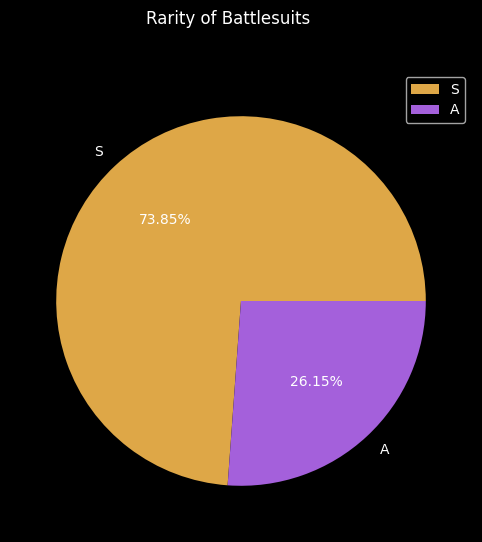

In [7]:
from matplotlib import pyplot as plt

rarity_count = df["Default Rank"].value_counts()

rarity_colors = {
    "S": "#DEA747",
    "A": "#A460DB"
}

rarity_colors = [rarity_colors[rarity] for rarity in rarity_count.index]

plt.figure(figsize=(10, 6))

plt.suptitle("Rarity of Battlesuits")

plt.pie(
    rarity_count,
    labels=rarity_count.index,
    autopct="%1.2f%%",
    colors=rarity_colors
)

plt.legend()
plt.show()

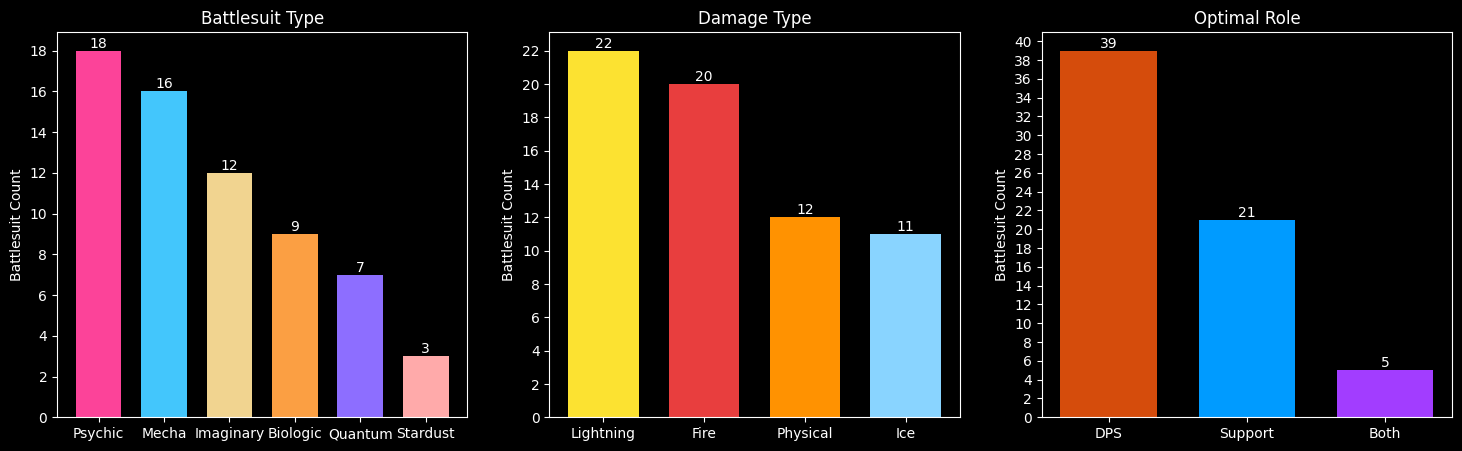

In [8]:
stats = {
    "Battlesuit Type": df["Battlesuit Type"].value_counts(),
    "Damage Type": df["Damage Type"].value_counts(),
    "Optimal Role": df["Optimal Role"].value_counts()
}

# all unique labels so colors can be combined in one dict
color_scheme = {
    "Psychic": "#FC4399",
    "Mecha": "#43C6FC",
    "Imaginary": "#F1D490",
    "Biologic": "#FB9F43",
    "Quantum": "#8D6EFF",
    "Stardust": "#FFAAAA",
    "Fire": "#E83E3E",
    "Lightning": "#FCE231",
    "Ice": "#89D4FF",
    "Physical": "#FF9201",
    "DPS": "#D54C0C",
    "Support": "#009BFF",
    "Both": "#A23DFF"
}

fig = plt.figure(figsize=(18, 5))

for i, stat in enumerate(stats, start=1):
    ax = fig.add_subplot(1, 3, i)
    
    ax.set_title(stat)
    ax.set_ylabel("Battlesuit Count")
    
    ax.set_yticks(range(0, max(stats[stat].values)+2, 2))
    
    colors = [color_scheme[info] for info in stats[stat].index]
    
    bar_graph = ax.bar(
        stats[stat].index,
        height=stats[stat].values,
        width=0.7,
        color=colors
    )
    
    plt.bar_label(
        bar_graph,
        label=stats[stat].values,
        label_type="edge"
    )

plt.show()

The data will deepen our AI's judgement/understanding for Psychic, Lightning, and/or DPS battlesuits more in comparison to others since there is an abundance of these types.

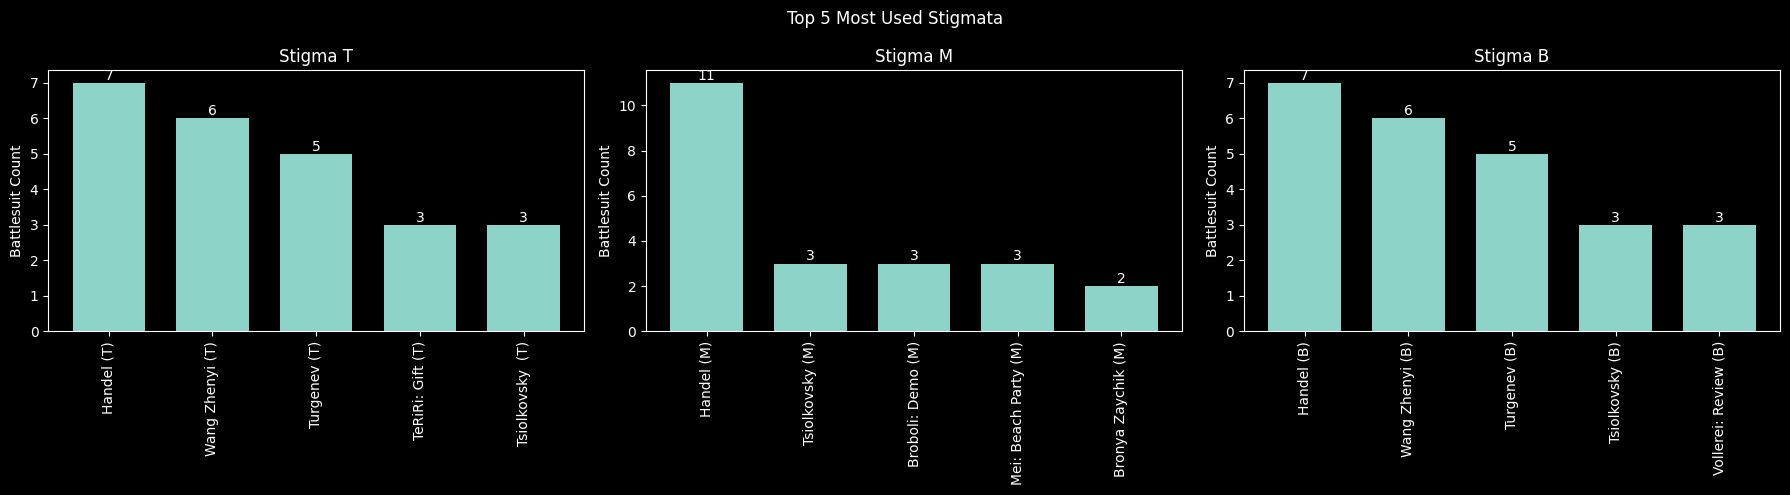

In [9]:
# get first 5 rows (biggest quantities descending)
stigma_data = {
    "T": df["Stigma (T)"].value_counts().iloc[:5],
    "M": df["Stigma (M)"].value_counts().iloc[:5],
    "B": df["Stigma (B)"].value_counts().iloc[:5]
}
fig = plt.figure(figsize=(18, 5))
fig.suptitle("Top 5 Most Used Stigmata")

for i, stigma in enumerate(stigma_data, start=1): # iterates over keys
    ax = fig.add_subplot(1, 3, i)
    
    ax.set_title(f"Stigma {stigma}")
    ax.set_ylabel("Battlesuit Count")
    
    bar_graph = ax.bar(
        stigma_data[stigma].index,
        height=stigma_data[stigma].values,
        width=0.7
    )
    
    plt.bar_label(
        bar_graph,
        labels=stigma_data[stigma].values,
        label_type="edge"
    )
    
    ax.tick_params("x", labelrotation=90)

plt.tight_layout() # avoid cutting off x-axis labels

plt.show()

There will be a bias in Handel stigmata along with Wang Zhenyi due to their abundance (that is, the AI model will recognize these stigmata's uses more than others).

Could it be that Psychic battlesuits happen to use Handel stigmata? Let's check with a Chi-Square test...

In [10]:
# test of independence - if two variables are independent
from scipy.stats import chi2_contingency

battlesuit_stigmata = df.loc[df["Battlesuit Type"] == "Psychic", ["Battlesuit", 'Stigma (T)', 'Stigma (M)', 'Stigma (B)']]
battlesuit_stigmata = pd.get_dummies(battlesuit_stigmata) # strings -> floats, one hot encoding

# test statistics, p-value, degrees of freedom, expected table
stat, p, dof, expected = chi2_contingency(battlesuit_stigmata)
print(f"p value: {p:.5f}")
print("A Psychic battlesuit is related to equipping Handel stigmata") if p <= 0.05 else print("A Psychic battlesuit is not related to Handel stigmata")

p value: 0.53228
A Psychic battlesuit is not related to Handel stigmata


## 3. Excel -> NumPy, Preprocessing

In [11]:
# convert for easier & faster calculations
df = df.to_numpy(dtype=str)

In [12]:
def get_column_value(array: np.ndarray, row: int, max_chars: int=25):
    print("Column, Value")
    for i, column in enumerate(array[row, :]):
        value = column
        if len(column) > max_chars:
            value = value[:max_chars] + "..."
        print(f"{i}: {value}")

In [13]:
# replace NaN with "-999"
# first convert np.nan to string and then compare
nan_str = np.array([np.nan]).astype(str)[0]

df[np.where(df.astype(str)==nan_str)] = -999
get_column_value(df, 0)

Column, Value
0: Schicksal's Imperative
1: 2024-09-05 00:00:00
2: S
3: Quantum
4: Lightning
5: DPS
6: Vacation Notice
7: Day After Day (T)
8: Day After Day (M)
9: Day After Day (B)
10: 371, 113, 77, 0, 0
11: 434, 0, 236, 8, 0
12: 388, 59, 86, 13, 0
13: DPS
14: Support
15: Activates World Star and ...
16: Build up Stress during Do...
17: Evade or jump to dodge en...
18: Attack together with pupp...
19: Fight using the Request-D...
20: Schicksal's Imperative fa...
21: Fight using the Message-B...
22: Unleash the power of Astr...
23: -999


### NumPy Bracket Notation
Let `df` be the variable of the row by column NumPy array.

In the brackets, the first parameter lets you select rows, while the second parameter selects the columns.\
Format: df[`row`, `column`]

Examples:

`df[5, 6]` - This selects the 6th row and the 7th column\
`df[:, 1]` - This selects all rows in the 2nd column\
`df[3:, :]` - This selects the 4th row and onwards for all columns\
`df[0, 0]` - This selects the 1st row and column

For indices that return multiple results, they are returned in NumPy arrays

In [14]:
df[0, :]

array(["Schicksal's Imperative", '2024-09-05 00:00:00', 'S', 'Quantum',
       'Lightning', 'DPS', 'Vacation Notice', 'Day After Day (T)',
       'Day After Day (M)', 'Day After Day (B)', '371, 113, 77, 0, 0',
       '434, 0, 236, 8, 0', '388, 59, 86, 13, 0', 'DPS', 'Support',
       "Activates World Star and unlocks enhancements based on the number of team members with the Domain Resonance trait.\nWorld Star is activated when Schicksal's Imperative is the leader.\nAstral Ring Intensity cost: 150. Stellar Outburst duration: 25s. CD: 25s.\nWhen there is at least 1 team member with the Domain Resonance trait, all team members deal 10.0% more Elemental DMG in Astral Ring Charging state.\nWhen there are at least 2 team members with the Domain Resonance trait, Schicksal's Imperative's Resonance Attack deals 10.0% more Total DMG.\nWhen there are 3 team members with the Domain Resonance trait, enemies take 10.0% more Lightning DMG from Schicksal's Imperative's Resonance (independent).\nSchick

In [15]:
# drop the two columns we dont need
# name & date @ [0, 1], stigma stats @ [10, 12]
df = np.delete(df, np.concatenate((np.arange(0, 2), np.arange(10, 13))), axis=1)

In [16]:
# replace newlines with spaces
df = np.char.replace(df, "\n", " ")

In [17]:
# double check that we dropped it correctly
# there should be no stigmata stats or names/dates
get_column_value(df, 0)

Column, Value
0: S
1: Quantum
2: Lightning
3: DPS
4: Vacation Notice
5: Day After Day (T)
6: Day After Day (M)
7: Day After Day (B)
8: DPS
9: Support
10: Activates World Star and ...
11: Build up Stress during Do...
12: Evade or jump to dodge en...
13: Attack together with pupp...
14: Fight using the Request-D...
15: Schicksal's Imperative fa...
16: Fight using the Message-B...
17: Unleash the power of Astr...
18: -999


From the given column values, we want to sort out our features and labels into separate arrays. Labels are from column values [4, 7], while the rest are in a features array

Array -> Features & Labels

**FEATURES**: `"Default Rank"`, `"Battlesuit Type"`, `"Damage Type"`, `"Optimal Role"`, `"World Star Optimal Role"`, `"Wheel of Destiny Optimal Role"`, etc...\
**LABELS**: `"Optimal Weapon"`, `"Stigma (T)"`, `"Stigma (M)"`, `"Stigma (B)"`

In [18]:
# arrange labels into another array
# 5-8 columns are labels

labels_arr = df[:, 4:8].astype(str)
print(labels_arr[2, :])
get_column_value(labels_arr, 2)
print(labels_arr.shape)

['Electrifying Arc' 'Von Neumann (T)' 'Von Neumann (M)' 'Von Neumann (B)']
Column, Value
0: Electrifying Arc
1: Von Neumann (T)
2: Von Neumann (M)
3: Von Neumann (B)
(65, 4)


In [19]:
# make sure the features/labels are separated correctly by checking via slice
# arrange features into a new numpy array

#features_arr = np.c_[df[:, :4], df[:, 8:]] # concatenate columns
features_arr = np.concatenate((df[:, :4], df[:, 8:]), axis=1, dtype=str)
get_column_value(features_arr, 0)
print(features_arr.shape)
print(features_arr.dtype)

Column, Value
0: S
1: Quantum
2: Lightning
3: DPS
4: DPS
5: Support
6: Activates World Star and ...
7: Build up Stress during Do...
8: Evade or jump to dodge en...
9: Attack together with pupp...
10: Fight using the Request-D...
11: Schicksal's Imperative fa...
12: Fight using the Message-B...
13: Unleash the power of Astr...
14: -999
(65, 15)
<U2100


In [20]:
# TODO see if there's a better way to do this
# make nested list of features into one unique list
# split spaces from columns 6-13
words_raw = []
for row in tqdm(features_arr[:, 6:14]):
    for sentence in row:
        words = sentence.split(" ")
        words_raw.extend(words)
words_raw = np.unique(np.array(words_raw))
print(words_raw.shape, words_raw[:9])

  0%|          | 0/65 [00:00<?, ?it/s]

(3670,) ['' '&' "'n'" '(1166%' '(200' '(3' '(3rd,' '(3~7)' '(50.0']


Prepare features/labels as tokens/classes for BERT model

In [21]:
# model params
LEARNING_RATE = 1e-3
DROPOUT = 0.5
EPOCHS = 10
#MAX_LEN = len(max(features_arr[0, :], key=len))
MAX_LEN = max(len(str(col)) for row in features_arr for col in row)
print(MAX_LEN)
# LABELS will be defined down the doc

2100


In [22]:
# simulate using tokenizer
# input_ids, token_type_ids, attention_mask
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
first_row_tokens = [tokenizer(token, padding="max_length", max_length=MAX_LEN, truncation=True, return_tensors="pt") for token in tqdm(features_arr[0, :])]
input_id, attention_mask = first_row_tokens[0]["input_ids"], first_row_tokens[0]["attention_mask"]
print(f"Length of Tokens List: {len(first_row_tokens)}")
print(f"Input ID Shape: {input_id.shape}")
print(f"Attention Mask Shape: {attention_mask.shape}")
print(f"Input ID Sample: {input_id[:2]}")
print(f"Attention Mask Sample: {attention_mask[:2]}")

  0%|          | 0/15 [00:00<?, ?it/s]

Length of Tokens List: 15
Input ID Shape: torch.Size([1, 2100])
Attention Mask Shape: torch.Size([1, 2100])
Input ID Sample: tensor([[101, 156, 102,  ...,   0,   0,   0]])
Attention Mask Sample: tensor([[1, 1, 1,  ..., 0, 0, 0]])


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in range(labels_arr.shape[1])]

for i, col in enumerate(labels_arr.T): # transposed, columns as rows
    label_encoders[i].fit(col)

In [ ]:
# get number of features and labels
unique_labels = sum(len(label_encoder.classes_) for label_encoder in label_encoders)# number of unique labels
FEATURES = features_arr.shape[1]

print(FEATURES, unique_labels)

15 185


In [25]:
# mostly stigmas
label_encoders[0].classes_

array(['Abyss Flower: Liminal Spiral', 'Anchor of the Voyage',
       'Astral Divide: Pisces', 'Banquet Rose', "Basilik's Image",
       'Blast Hammer', 'Bloodied Casket', 'Burn the Long Night',
       'Cosmic Duality', 'Crusher Bunny 19C', 'Domain of Ascension',
       'Domain of Ego', 'Domain of Genesis', 'Domain of Incandescence',
       'Domain of Sentience', 'Domain of Unity', 'Dream Cutter',
       'Echo of Paradise', 'Electrifying Arc',
       "Elysian Astra: Heart's Color", 'Falcon Flare',
       'Falcon Flare: FINAL', 'Iris of Helheim', 'Life Harvester',
       'Lost Conviction', 'Midnight Ataegina', 'Miracle Kissy Pillow',
       'Mitternachts Waltz', 'Nocturnal Stealth', 'Oblivion Down',
       'Obscuring Wing', "Pandora's Box 18th", 'Prophetic Dreams',
       'Purana Phantasma: Nighteye', 'Purge of Ten Faces',
       'Red Star Thunderbolt', 'Rudder in Dream', 'Sagittarius Astra',
       'Sanguine Gaze: Union', 'Seven Thunders', 'Star Dance',
       'Star of Eden: World', 'T

In [26]:
label_test = label_encoders[0].transform(labels_arr[:, 0]).astype(np.uint16)
label_test

array([45, 35, 18,  3,  7, 34,  5,  6,  1, 17, 15, 39, 24,  4, 42, 12, 36,
       16,  2, 13, 11, 28, 40, 10, 20, 41, 23, 14, 32, 47, 25, 30, 27, 46,
       19, 33, 26, 31, 44, 22, 22, 43, 37, 38,  9, 21,  8,  0,  6,  6,  6,
        6, 15, 15, 39, 24,  6,  6,  8, 29, 12, 12, 33, 33, 16],
      dtype=uint16)

### 3.1 Make Dataset

In [27]:
from pathlib import Path

EXCEL_FILE_PATH = Path.joinpath(Path.cwd(), "HI3_Data.xlsx")

In [28]:
# # TODO: batches -> torch tensors
# this will be uncommented when dataset gets bigger
# import os
# import openpyxl
# from typing import List
# from torch.utils.data import IterableDataset
# from sklearn.feature_extraction.text import CountVectorizer

# class HI3Dataset(IterableDataset):
#     def __init__(self,
#                  file_path: str | os.PathLike,
#                  mode: str=None,
#                  use_columns: list=None,
#                  exclude_columns: list=None
#                  ):
#         """Streams an Excel file of Honkai Impact 3rd builds into memory when required.
#         Args:
#             file_path: The file path of the Excel file storing character builds
#             mode: "train" or "test" to provide a training/testing dataset with preset columns. Can be overridden by use_columns & exclude_columns
#             use_columns: A 1-indexed list of columns for the dataset to read (inclusive) (can include excluded columns).
#             exclude_columns: A 1-indexed list of columns for the dataset to skip (inclusive) (can be in the use_columns range)"""
#         raw_wb = openpyxl.load_workbook(file_path, read_only=True)
#         self.ws = raw_wb.active
#         self.max_row = self.ws.max_row
#         self.excluded = None
#         self.nan = {"=NA()": "-999"}
        
#         assert mode is not None or use_columns is not None or exclude_columns is not None, "Must set keyword arguments for either mode or use_columns"
#         if mode is not None:
#             match mode.lower():
#                 case "train":
#                     self.min_col, self.max_col = 3, self.ws.max_column
#                     self.excluded = range(7, 14)
#                 case "test":
#                     self.min_col, self.max_col = 7, 10
#                 case _:
#                     raise Exception("Mode argument must be \"train\" or \"test\" (case-insensitive)")
#         else:
#             self.min_col, self.max_col = use_columns
#             if exclude_columns is not None:
#                 self.excluded = range(exclude_columns[0], exclude_columns[1]+1)
    
#     def __preprocess(self, arr: np.ndarray) -> None:
#         """Preprocesses the NumPy array into a PyTorch Tensor in-place."""
#         arr[np.where(arr==self.nan.keys())] = self.nan.values()
        
        
#     def __iter__(self):
#         for i, row in enumerate(self.ws.iter_rows(min_row=2, max_row=self.ws.max_row, min_col=self.min_col, max_col=self.max_col, values_only=True)):
#             if self.excluded is not None and i in self.excluded: # skip the row
#                 continue
#             arr = np.array(row, dtype=str)
#             arr[np.where(arr==self.nan.keys())] = self.nan.values()
#             yield arr
    
#     def __getitem__(self, index):
#         """Fetch a row from the dataset with a zero-indexed slice or index."""
#         arguments = {
#             "min_col": self.min_col,
#             "max_col": self.max_col,
#             "values_only": True
#         }
        
#         if isinstance(index, slice):
#             assert index.step is None, "Slicing step is not supported for indexing rows"
#             if index.start is not None:
#                 arguments["min_row"] = index.start + 2
#             else:
#                 arguments["min_row"] = 2 #dont select header
#             if index.stop is not None: 
#                 arguments["max_row"] = index.stop + 1
#             else:
#                 arguments["max_row"] = self.max_row
#         else:
#             arguments["min_row"] = index + 2
#             arguments["max_row"] = index + 2
        
#         if "min_row" in arguments and "max_row" in arguments and arguments["min_row"] == arguments["max_row"]:
#             arr = np.array(
#                 next(self.ws.iter_rows(**arguments)),
#                 dtype=str
#             )
#         else:
#             arr = np.fromiter(self.ws.iter_rows(**arguments), dtype=object)
#             arr = np.array(arr.tolist(), dtype=str) # remove tuples, make them rows
        
#         arr[np.where(arr==self.nan.keys())] = self.nan.values()
#         return arr

#     def __len__(self):
#         return self.ws.max_row - 1 # header row is included
        

# train_ds = HI3Dataset(EXCEL_FILE_PATH, mode="train") #["C:F", "N:X"], 14-24
# test_ds = HI3Dataset(EXCEL_FILE_PATH, mode="test") # [G:J]

In [29]:
# TODO use _label_index
import os
from torch.utils.data import Dataset
from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder

class HI3Dataset(Dataset):
    def __init__(self,
                 file_path: str | os.PathLike,
                 *use_columns,
                 train: bool=True,
                 train_size: float=None,
                 test_size: float=None,
                 model_name: str="bert-base-uncased",
                 labels: list=None
                 ):
        """Streams an Excel file of Honkai Impact 3rd builds into memory, preprocessing the data into tokens and classes. By default, it will load the entire dataset.
        The NaN values are customizable through the attribute nan_values.
        Note: The dataset is not preprocessed/encoded until you choose to split the dataset (to prevent label encoding leakage).
        Args:
            file_path: The file path of the Excel file storing character builds
            model_name: The model name of BERT to be used (available in HuggingFace Documentation)
            labels: A list of label column names to use from the dataset if not None. Defaults to Optimal Weapon & Stigma (T/M/B) columns if not set.
            use_columns: A 0-indexed args parameter that allows manual input of columns to use for a dataset (inclusive)"""
        
        self.nan = {k:"-999" for k in ["nan"]}        
        columns = use_columns if use_columns else None
        
        self.ws = pd.read_excel(file_path, usecols=columns)
        self._label_index = {}
        self._column_index = {v:k for k, v in enumerate(self.ws.columns)} # format: name, index
        self._index_column = {k:v for k, v in enumerate(self.ws.columns)}
        
        self._labels = labels if labels is not None else ["Optimal Weapon", "Stigma (T)", "Stigma (M)", "Stigma (B)"]
        self._features = [feature for feature in self._column_index.keys() if feature not in self._labels]
        self.label_encoders = [LabelEncoder() for _ in range(len(self._labels))]
        
        assert (train and train_size is not None) or (not train and test_size is not None), "Either train must be True with a specified train_size argument or train must be False with a specified test_size argument."
        
        self.ws = self.ws.to_numpy(dtype=str) # important! helps tokenizer recognize stuff
        
        if train_size is None:
            train_size = 1.0 - test_size
        
        split = int(train_size*self.ws.shape[0])
        
        self.ws = self.ws[:split] if train else self.ws[split:]
        
        #input_ids, token_type_ids, attention_mask
        self.max_row = self.ws.shape[0]
        self.labels_arr: torch.Tensor = torch.zeros(self.max_row, len(self._labels), dtype=torch.int64)
        self.input_ids, self.token_type_ids, self.attention_mask = [], [], []
        
        # needed for tokenizer
        #self.vocab = self.get_vocab()
        self.max_len = self._get_max_len()
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        
        # everything -> numbers
        # removes self.ws
        self.__preprocess()
    
    
    @property
    def nan_values(self):
        return self.nan
    
    
    @nan_values.setter
    def nan_values(self, new_nan: str):
        """Associates the given input to be registered as NaN by displaying it at -999"""
        self.nan[new_nan] = "-999"
    
    
    @property
    def classes(self):
        """Returns the column names that will be considered features or classes."""
        return self._features
    
    
    @property
    def labels(self):
        """Returns the column names that will be considered labels."""
        return self._labels
    
    
    @labels.setter
    def labels(self, new_labels: list):
        """Replaces the current list of labels with a new list of labels.
        This automatically sets the features of the dataset and resets the LabelEncoders."""
        self._labels = new_labels
        self._features = [feature for feature in self._column_index.keys() if feature not in self._labels]
        self.label_encoders = [LabelEncoder() for _ in range(len(self._labels))]
    
    
    @property 
    def label_columns(self) -> dict:
        """Returns the indices and label column names that correspond to each other.
        Format: Index: Label Column Name"""
        return self._label_index

    
    @property
    def num_labels(self):
        """Returns the number of unique labels in the entire dataset"""
        count = 0
        for label_encoder in self.label_encoders:
            count += label_encoder.classes_
        return count
    
    
    @property
    def num_features(self):
        """Returns the number of unique features in the entire dataset"""
        return len(self.column_names)
    
    
    @property
    def label_names(self):
        """Returns the names of all the unique labels in the dataset."""
        # this is 1D
        # also what in the java is this approach
        labels = []
        for label_encoder in self.label_encoders:
            labels.extend(label_encoder.classes_)
        
        return labels
            
        
    @property
    def num_rows(self):
        """Returns the number of rows in the dataset's instance."""
        return self.max_row
    
    
    @property
    def column_names(self) -> dict:
        """Format: Column Name: Index"""
        return self._column_index


    #@property
    #def vocabulary(self) -> np.ndarray:
        #return self.vocab
    
    
    def get_label_encoders(self) -> list:
        """Returns all LabelEncoders in a list (corresponding to label columns that come first)"""
        return self.label_encoders
    
    
    # doesnt support pytorch tens since it cant have strings
    def label2arr(self, arr: np.ndarray | list) -> np.ndarray:
        """Returns a same-sized array of transformed/encoded items (numbers) from the dataset's LabelEncoder
        i.e.: ['Domain of Ascension', 'Day After Day (T)', 'Day After Day (M)', "Leaf's Visions (B)"] -> [10, 11, 11, 18]"""
        if isinstance(arr, np.ndarray):
            assert arr.ndim == 1, f"Array must be a sample of labels with only one categorical label. Must be 1D, got {arr.ndim}D"
        
        labels: list = []
        
        for label_encoder, label in zip(self.label_encoders, arr):
            labels.append(label_encoder.transform(np.array([label])).item())
        
        return labels


    def arr2label(self, arr: np.ndarray | torch.Tensor) -> list:
        """Returns a same-sized 2D array of inverse-transformed items (english) from the dataset's LabelEncoder
        i.e.: [10, 11, 11, 18] -> ['Domain of Ascension', 'Day After Day (T)', 'Day After Day (M)', "Leaf's Visions (B)"]"""
        if isinstance(arr, torch.Tensor): # pytorch
            assert arr.dim() == 1, f"Array must be a sample of labels with only one categorical label. Must be 1D, got {arr.dim()}D"
                        
        else: # numpy
            assert arr.ndim == 1, f"Array must be a sample of labels with only one categorical label. Must be 1D, got {arr.ndim}D"
        
        labels: list = []
                
        #labels = labels.reshape(-1, 1) # reshape for compatability, cannot transform scalars
            
        for label_encoder, label in zip(self.label_encoders, arr):
            labels.append(label_encoder.inverse_transform(np.array([label])).item()) # reshape could work too)
        
        return labels
        
    
    def _get_max_len(self) -> int:
        """Returns the length of the longest item in the dataset"""
        col_lens = np.array([0]*self.ws.shape[1], dtype=np.uint32) # hopefully you dont exceed this
        for i, col in enumerate(self.ws.T):
            try:
                col_lens[i] = len(max(col, key=len))
            except TypeError: # cannot parse, usually a timestamp
                continue
        
        return int(max(col_lens))
        
    
    def __preprocess(self):
        """Preprocesses the NumPy dataset array in-place before encoding"""
        assert hasattr(self, "ws"), "The original dataset has already been split into feature and label datasets. There is no need to run this function..."
        # nan and newlines
        self.ws[np.where(self.ws==self.nan.keys())] = self.nan.values()
        self.ws = np.char.replace(self.ws, "\n", " ")
        
        # encode feature columns
        for row in tqdm(self.ws, "Encoding features and adding to lists..."):
            row_tokens = self.tokenizer(
                row.tolist(),
                padding="max_length",
                max_length=self.max_len,
                truncation=True, # prob wont happen but just in case
                return_tensors="pt"
            )
            
            self.input_ids.append(row_tokens["input_ids"])
            self.token_type_ids.append(row_tokens["token_type_ids"])
            self.attention_mask.append(row_tokens["attention_mask"])

        # encode label through columns
        label_slice = [*[self._column_index[label_idx] for label_idx in self._labels]]
        
        # encode labels & transfer
        for i, col_idx in tqdm(enumerate(label_slice), "Encoding labels and adding to lists..."):
            self._label_index[self._index_column[col_idx]] = i
            self.labels_arr[:, i] = torch.from_numpy(self.label_encoders[i].fit_transform(self.ws[:, col_idx]))

        del self.ws

    
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Fetch a row from the dataset with a zero-indexed slice or index.
        Returns input ids, token_type_ids, attention masks, and corresponding labels from the dataset."""
        if isinstance(index, slice):
            start = index.start if index.start is not None else 0
            stop = index.stop if index.stop is not None else len(self.input_ids) - 1
            step = index.step if index.step is not None else 1
            
            return self.input_ids[start:stop:step], self.token_type_ids[start:stop:step], self.attention_mask[start:stop:step], self.labels_arr[start:stop:step]
        else:
            return self.input_ids[index], self.token_type_ids[index], self.attention_mask[index], self.labels_arr[index]


    def __len__(self):
        return self.max_row

#### Split the dataset into training and validation sets

Since the class only creates one dataset, we must split the dataset manually into two so we can have a dedicated training and testing dataset.

In [30]:
# get the actual dataset first
# exclude name, date, and max stigma stats
raw_train_ds = HI3Dataset(EXCEL_FILE_PATH, *range(2, 10), *range(13, 24), train=True, train_size=0.8)
test_ds = HI3Dataset(EXCEL_FILE_PATH, *range(2, 10), *range(13, 24), train=False, test_size=0.2)

len(raw_train_ds), len(test_ds)

Encoding features and adding to lists...:   0%|          | 0/52 [00:00<?, ?it/s]

Encoding labels and adding to lists...: 0it [00:00, ?it/s]

Encoding features and adding to lists...:   0%|          | 0/13 [00:00<?, ?it/s]

Encoding labels and adding to lists...: 0it [00:00, ?it/s]

(52, 13)

In [31]:
# create validation dataset by splitting training dataset into two
from torch.utils.data import random_split

train_ds: torch.utils.data.dataset.Subset
valid_ds: torch.utils.data.dataset.Subset
train_ds, valid_ds = random_split(
    raw_train_ds,
    [0.8, 0.2]
)
len(train_ds), len(valid_ds)

(42, 10)

In [32]:
train_ds.dataset.column_names

{'Default Rank': 0,
 'Battlesuit Type': 1,
 'Damage Type': 2,
 'Optimal Role': 3,
 'Optimal Weapon': 4,
 'Stigma (T)': 5,
 'Stigma (M)': 6,
 'Stigma (B)': 7,
 'World Star Optimal Role': 8,
 'Wheel of Destiny Optimal Role': 9,
 'Leader Buff': 10,
 'Passive Buff': 11,
 'Evasion': 12,
 'Weapon Skills': 13,
 'Basic ATK': 14,
 'Ultimate': 15,
 'Special Attack': 16,
 'Astral Ring': 17,
 'SP': 18}

In [33]:
# let's see how our data looks like when we loop through it
experiment_ds = HI3Dataset(EXCEL_FILE_PATH, *range(2, 10), *range(13, 24), train=True, train_size=0.8, test_size=0.2)

Encoding features and adding to lists...:   0%|          | 0/52 [00:00<?, ?it/s]

Encoding labels and adding to lists...: 0it [00:00, ?it/s]

In [34]:
sample = experiment_ds[0]
print(f"Input IDs: {sample[0][:2]}")
print(f"Attention Mask: {sample[1][:2]}")
print(f"Input ID Shape: {sample[0].size()}")
print(f"Attention Mask Shape: {sample[1].size()}")

Input IDs: tensor([[ 101, 1055,  102,  ...,    0,    0,    0],
        [ 101, 8559,  102,  ...,    0,    0,    0]])
Attention Mask: tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Input ID Shape: torch.Size([19, 2100])
Attention Mask Shape: torch.Size([19, 2100])


Note how our tensors have a shape of 2100 for each row which exceeds the token limit of 512 for BERT. We can either truncate the tokens we have to conform to BERT's usual token limit, or we can use libraries that leverage these numerable tokens. One comes at the risk of learning while one at the risk of memory (which can be countered).

If we want to truncate, we can either:
- Truncate the first few pieces of text
- Truncate the last few pieces of text
- Truncate the middle of the text
  - outperforms chunking info, classifying, & gathering up together which is more expensive
  - works better than cutting out the beginning of the text
  - [research paper link to this evidence](https://doi.org/10.48550/arXiv.1905.05583)

In [35]:
def truncate_mid(tens: torch.Tensor, token_limit: int=512) -> torch.Tensor:
    """Removes the middle third of a tensor to fit 2nd dimension within the token_limit parameter. Assumes the tensor is 2D and does not account for batch size."""
    assert token_limit < tens.size(-1), f"The provided {token_limit} token limit is greater than the 2nd dimension of the tensor with a size of {tens.size(-1)}. Change token_limit to be equal to {tens.size(-1)} or less."
    size = tens.size(-1)
    
    removed_chunk = size - token_limit # this is where chunk ends, or how long it is
    
    # after removing middle, choose the left as the first
    first = (size - removed_chunk) // 2
    
    # the second half starts after removed chunk
    last = first + removed_chunk # can also be token_limit
    
    return torch.cat((tens[:, :first], tens[:, last:]), dim=1)

This is a visualizer of what the `truncate_mid()` method does, where the color-coded text corresponds to the end of the slice it makes.
<br>
<br>
<img src="./static/images/truncate_mid_visualizer.png" height=508 width=708 alt="4 Boxes of a Tensor being Sliced by Its Local Variables">

In [36]:
test_tens = torch.zeros((15, 30))
test_tens.size()

torch.Size([15, 30])

In [37]:
# modify middle third to be all ones
test_tens[:, 10:20] = torch.ones((test_tens.size(0), 10))
test_tens.size()

torch.Size([15, 30])

In [38]:
test_tens[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The `truncate_mid()` should be removing the middle third of the entire tensor, so we should not be able to see any ones after the split.

In [39]:
new_tens = truncate_mid(test_tens, token_limit=20)
new_tens.size()

torch.Size([15, 20])

In [40]:
# et voila!
new_tens[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### 3.2 Make Dataloader

In [41]:
# prep dataloader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 2
# allow multiple cores to run dataloader
os.environ["TOKENIZERS_PARALLELISM"] = "true"

train_dataloader = DataLoader(train_ds.dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_ds.dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

In [42]:
len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(26, 26, 7)

In [43]:
# we need these label encoders for later (use training, not testing)
label_encoders: list = train_ds.dataset.get_label_encoders()
label_encoders

[LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()]

In [44]:
experimental_dataloader = DataLoader(experiment_ds, batch_size=BATCH_SIZE, num_workers=os.cpu_count())

test_bert = BertModel.from_pretrained("bert-base-uncased")

In [45]:
# input ids, token_type_ids, attention masks, and corresponding labels
test_tokens = next(iter(experimental_dataloader))
len(test_tokens)

4

In [46]:
# doing this to prove that unpacking dataloader is possible
meow1, meow2, meow3, meow4 = test_tokens
meow1.size(), meow2.size(), meow3.size(), meow4.size()

(torch.Size([2, 19, 2100]),
 torch.Size([2, 19, 2100]),
 torch.Size([2, 19, 2100]),
 torch.Size([2, 4]))

In [47]:
# this simulates going through batches
for batch in range(test_tokens[0].size(0)):
    input_id = test_tokens[0][batch]
    token_type_id = test_tokens[1][batch]
    attention_mask = test_tokens[2][batch]
    batch_label = test_tokens[3][batch]
    print(f"Batch {batch+1}:", end=" ")
    print(input_id.size(), token_type_id.size(), attention_mask.size(), batch_label.size())

Batch 1: torch.Size([19, 2100]) torch.Size([19, 2100]) torch.Size([19, 2100]) torch.Size([4])
Batch 2: torch.Size([19, 2100]) torch.Size([19, 2100]) torch.Size([19, 2100]) torch.Size([4])


In [48]:
# there are batches!!
# test_tokens[3] are the labels
test_tokens[0].size(), test_tokens[1].size(), test_tokens[2].size(), test_tokens[3].size()

(torch.Size([2, 19, 2100]),
 torch.Size([2, 19, 2100]),
 torch.Size([2, 19, 2100]),
 torch.Size([2, 4]))

The formatting is fairly confusing, so this is how it should be broken down (from test_tokens):

`[batch tensor of INPUT_IDS, batch tensor of TOKEN_TYPE_IDS, batch tensor of ATTENTION_MASKS, batch tensor of LABELS]`

Note that each list item will have batches, so we must iterate through each tensor to get each batch's information.

To access the `n`th batch of an input id, we would index like so:\
`test_tokens[0][n]`

We index the 0th element to reference all input ids before getting the nth batch.

In [49]:
# labels are in encoding
test_tokens[3][0]

tensor([44, 11, 11,  9])

In [50]:
# wowzas the tensors have 512 tokens and not 2100!!
test_input_id = truncate_mid(test_tokens[0][0])
test_token_type_id = truncate_mid(test_tokens[1][0])
test_attention_mask = truncate_mid(test_tokens[2][0])
print(test_input_id.size(), test_token_type_id.size(), test_attention_mask.size())

torch.Size([19, 512]) torch.Size([19, 512]) torch.Size([19, 512])


In [51]:
_, test_pred = test_bert(input_ids=test_input_id, token_type_ids=test_token_type_id, attention_mask=test_attention_mask, return_dict=False)

In [52]:
len(test_pred), type(test_pred)

(19, torch.Tensor)

In [53]:
test_pred.size()

torch.Size([19, 768])

In [54]:
experimental_dataloader.dataset.labels

['Optimal Weapon', 'Stigma (T)', 'Stigma (M)', 'Stigma (B)']

In [55]:
# now plug into a linear layer that classifies into our labels!!
from torch.nn import Linear, Dropout, ReLU
classifier_layer = Linear(in_features=768, out_features=len(experimental_dataloader.dataset.labels))
dropout_layer = Dropout(0.5)
activation_layer = ReLU()

In [56]:
with torch.inference_mode():
    dropout_output = dropout_layer(test_pred)
    print(f"Dropout Output Size: {dropout_output.size()}")
    relu_output = activation_layer(dropout_output)
    print(F"ReLU Output Size: {relu_output.size()}")
    
    result_logits = torch.softmax(classifier_layer(dropout_output), dim=0) #column-wise
    print(f"Logit Size: {result_logits.size()}, First Row Results: {result_logits[0]}")
    
    result_preds = torch.argmax(result_logits, dim=0)
    eng_preds = experimental_dataloader.dataset.arr2label(result_preds)
    print(f"Prediction Size: {result_preds.size()}, Results: {result_preds}, Translated: {eng_preds}")
    
    actual_labels = experimental_dataloader.dataset.arr2label(test_tokens[3][0])
    print(f"Actual Labels: {actual_labels}")
    
    actual_encoded_labels = experimental_dataloader.dataset.label2arr(actual_labels)
    print(f"Actual (Encoded) Labels: {actual_encoded_labels}")
    # converted back
    print("Prediction Converted Back (to Encoding): ", end="")
    print(experimental_dataloader.dataset.label2arr(eng_preds))

Dropout Output Size: torch.Size([19, 768])
ReLU Output Size: torch.Size([19, 768])
Logit Size: torch.Size([19, 4]), First Row Results: tensor([0.0368, 0.0221, 0.0326, 0.0505])
Prediction Size: torch.Size([4]), Results: tensor([ 3, 14, 14, 11]), Translated: ['Banquet Rose', 'Fu Hua: Margrave (T)', 'Fu Hua: Margrave (M)', 'Elysia: Pristine (B)']
Actual Labels: ['Vacation Notice', 'Day After Day (T)', 'Day After Day (M)', 'Day After Day (B)']
Actual (Encoded) Labels: [44, 11, 11, 9]
Prediction Converted Back (to Encoding): [3, 14, 14, 11]


## 4. Define AI model

In [58]:
from torch import nn
from tqdm import tqdm
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy
from transformers import BertModel

class BertClassifier(nn.Module):
    
    available_models = [ # there's more but these are sufficient
        "bert-base-uncased",
        "bert-large-uncased",
        "bert-base-multilingual-uncased",
        "bert-large-uncased-whole-word-masking",
        "bert-base-cased",
        "bert-large-cased",
        "bert-base-multilingual-cased",
        "bert-large-cased-whole-word-masking"
    ]
    
    def __init__(
            self,
            dropout: float,
            features: int,
            labels: int,
            max_seq_len:int = 128,
            model="bert-base-uncased",
            device="cuda"
        ):
        """
        Parameters:
        dropout: The percentage of information to remove from model in training
        features: The number of features for the model to train on
        labels: The number of labels for the model to predict
        model: The pretrained (BERT) model from HuggingFace to use
        """
        super().__init__()
        
        assert model in self.available_models # make sure the model is valid
        
        self.bert = BertModel.from_pretrained(model, torch_dtype=torch.float32) # cant use fp16 unless data is also fp16
        self.tokenizer = BertTokenizerFast.from_pretrained(model)
        self.seq_len = max_seq_len
        
        self.LABELS = labels
        
        # metrics
        self.f1 = MulticlassF1Score(self.LABELS)
        self.accuracy = MulticlassAccuracy(self.LABELS)
        
        for param in self.bert.parameters(): # dont train bert
            param.requires_grad = False # orig required_grade
            
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.linear = nn.Linear(features, self.LABELS) #features, labels
        self.device = device if torch.cuda.is_available() else "cpu"
    
    def forward(
            self,
            input_ids,
            token_type_ids,
            attention_mask
        ):
        _, bert_output = self.bert(
            input_ids = input_ids,
            token_type_ids = token_type_ids,
            attention_mask = attention_mask,
            return_dict = False
        )
        
        dropout_output = self.activation(self.dropout(bert_output))
        final_output = self.linear(dropout_output)
        
        return final_output
    
    
    def train_model(
            self,
            train_loader: torch.utils.data.DataLoader,
            valid_loader: torch.utils.data.DataLoader,
            loss_fn,
            optimizer: torch.optim.Optimizer,
            batch_size: int,
            num_epochs: int,
            model_path: str
        ):
        """
        train_loader: Data loader for train dataset
        valid_loader: Data loader for validation dataset
        loss_fn: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs
        model_path: Path to save the model
        """
        best_loss = 1e8 #0.00000001
        best_f1 = 0
        for i in range(num_epochs):
            print(f"Epoch {i+1}/{num_epochs}")
            valid_loss, train_loss, f1_valid = [], [], []
            
            self.train()
            # train loop
            for input_ids, token_type_ids, attention_masks, batch_labels in tqdm(train_loader):
                # move to gpu
                input_ids = input_ids.to(self.device)
                token_type_ids = token_type_ids.to(self.device)
                attention_masks = attention_masks.to(self.device)
                batch_labels = batch_labels.to(self.device)
                
                for batch in range(batch_size):                    
                    # truncate tokens
                    input_id = truncate_mid(input_ids[batch])
                    token_type_id = truncate_mid(token_type_ids[batch])
                    attention_mask = truncate_mid(attention_masks[batch])
                                        
                    # forward pass
                    batch_output = self.forward( # logits
                        input_ids = input_id,
                        token_type_ids = token_type_id,
                        attention_mask = attention_mask
                    )

                    y_preds = torch.softmax(batch_output, dim=0).argmax(dim=0) # encoded numbers like [12, 5, 6, 11]
                    
                    # calculate loss
                    loss = loss_fn(batch_output, batch_labels[batch])
                    train_loss.append(loss.item())
                    optimizer.zero_grad()

                    loss.backward()
                    
                    optimizer.step()
                
                
            self.eval()
            # validation loop
            for input_ids, token_type_ids, attention_masks, batch_labels in tqdm(valid_loader):
                # move to gpu
                input_ids = input_ids.to(self.device)
                token_type_ids = token_type_ids.to(self.device)
                attention_masks = attention_masks.to(self.device)
                batch_labels = batch_labels.to(self.device)
                
                for batch in range(batch_size):                    
                    # truncate tokens
                    input_id = truncate_mid(input_ids[batch])
                    token_type_id = truncate_mid(token_type_ids[batch])
                    attention_mask = truncate_mid(attention_masks[batch])
                    
                    with torch.inference_mode():
                        # forward pass
                        batch_output = self.forward( # logits
                            input_ids = input_id,
                            token_type_ids = token_type_id,
                            attention_mask = attention_mask
                        )

                        y_preds = torch.softmax(batch_output, dim=0).argmax(dim=0) # encoded numbers like [12, 5, 6, 11]
                        
                        # calculate loss
                        f1_valid.append(self.f1(y_preds, batch_labels[batch]).item())
                        valid_loss.append(loss_fn(batch_output, batch_labels[batch]).item())
                
            t_loss = np.mean(train_loss)  # avg training loss
            v_loss = np.mean(valid_loss)  # avg validation loss
            f1_valid_avg = np.mean(f1_valid)
            
            print(f"Train Loss: {t_loss:.2%}, Validation Loss: {v_loss:.2%}, F1 Score (Validation): {f1_valid_avg:.2f}")
            if v_loss < best_loss:
                best_loss = v_loss
                # save model if lower validation loss
                torch.save(self.bert.state_dict(), model_path)
            
            if f1_valid_avg > best_f1:
                best_f1 = f1_valid_avg
                
        print(f"Best Validation Loss [0, 100]: {best_loss:.2%}, Best F1 Score [0, 1]: {best_f1:.2f}")
    
    
    def test_model(
            self,
            test_loader: torch.utils.data.DataLoader,
            loss_fn,
            batch_size: int
        ):
        """
        Function to test the model
         test_loader: Data loader for test dataset
         model: Model object
         loss_fn: Loss function
         batch_size: Preferred batch size
        """
        self.eval()
        test_loss, test_acc, f1_score = [], [], []
        
        for input_ids, token_type_ids, attention_masks, batch_labels in tqdm(test_loader):
            # move to gpu
            input_ids = input_ids.to(self.device)
            token_type_ids = token_type_ids.to(self.device)
            attention_masks = attention_masks.to(self.device)
            batch_labels = batch_labels.to(self.device)
            
            for batch in range(batch_size):                
                input_id = truncate_mid(input_ids[batch])
                token_type_id = truncate_mid(token_type_ids[batch])
                attention_mask = truncate_mid(attention_masks[batch])
                
                # forward pass
                batch_output = self.forward(
                    input_ids = input_id,
                    token_type_ids = token_type_id,
                    attention_mask = attention_mask
                )                
                
                # calculate loss
                loss = loss_fn(batch_output, batch_labels[batch])
                test_loss.append(loss.item())
                y_preds = torch.softmax(batch_output, dim=0).argmax(dim=0)
                    
                # calculate accuracy
                test_acc.append(self.accuracy(y_preds, batch_labels[batch]).item())
            
                f1_score.append(self.f1(y_preds, batch_labels[batch].item()))
                
        test_loss = np.mean(test_loss)
        test_acc = np.mean(test_acc)
        avg_f1 = np.mean(f1_score)
        
        print(f"Test Loss: {test_loss:.2%}, Test Accuracy: {test_acc:.2%}, Average F1-Score: {avg_f1:.2f}")
    
    def predict(
            self,
            features: pd.DataFrame | np.ndarray | list,
            label_encoders: list
        ) -> list[str, str, str, str]:
        prediction = []
        
        if isinstance(features, pd.DataFrame):
            features = features.copy().to_numpy().tolist()
        elif isinstance(features, np.ndarray):
            features = features.tolist()
        
        self.eval()
        
        tokens = self.tokenizer(
            features,
            padding="max_length",
            max_length=MAX_LEN,
            truncation=True,
            return_tensors="pt"
        )
        
        input_id = tokens["input_ids"].to(self.device)
        token_type_id = tokens["token_type_ids"].to(self.device)
        attention_mask = tokens["attention_mask"].to(self.device)
        
        input_id = truncate_mid(input_id)
        token_type_id = truncate_mid(token_type_id)
        attention_mask = truncate_mid(attention_mask)
        
        with torch.inference_mode():
            out = self.forward(input_id, token_type_id, attention_mask)
            y_preds = torch.softmax(out, dim=0).argmax(dim=0)
            for y_pred, label_encoder in zip(y_preds, label_encoders):
                prediction.append(label_encoder.inverse_transform(y_pred.numpy()))
            
        return prediction

In [59]:
# model setup
LABELS = len(train_dataloader.dataset.labels) # ['Optimal Weapon', 'Stigma (T)', 'Stigma (M)', 'Stigma (B)']
model = BertClassifier(DROPOUT, FEATURES, LABELS)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# to gpu if applicable
model = model.to(device)
loss = loss.to(device)

In [60]:
model.train_model(train_dataloader, valid_dataloader, loss, optimizer, BATCH_SIZE, EPOCHS, "hi3builds.pth")

Epoch 1/10


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:03<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (19x768 and 15x4)

In [ ]:
model.test(test_dataloader, loss, device)

## 5. Validate the model with the validation datasets

## 6. Make a prediction with a new character